In [1]:
from marked_words import marked_words
import pandas as pd

def pprint(dic):
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
        print("%s, %.2f" % (word[0],word[1]))

In [11]:
df1=pd.read_csv('data/chatgpt/chatgpt_prompts56_generations.csv')
df2= pd.read_csv('data/generated_personas_chat_15_nb.csv')
df2.drop(0)
df2=df2.loc[(df2['prompt_num']==4)|(df2['prompt_num']==5)]
df2['race']=df2['race'].replace('a Latino', 'a Latine')

In [12]:
df=pd.concat([df1,df2])
df.to_csv('data/chatgpt_main_generations.csv')

In [14]:
df['prompt_num'].value_counts()

0    600
1    600
4    225
5    225
Name: prompt_num, dtype: int64

In [15]:
from marked_words import marked_words
import pandas as pd
from collections import Counter

def pprint(dic):
    full_list = []
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
#         print("%s, %.2f" % (word[0],word[1]))
        full_list.append(word[0])
    return full_list


In [16]:
dv3_mw = {}
for race in df['race'].unique():
#     print('\n Top words for %s \n-------' % race)
    outs = pprint(marked_words(df, [race], ['race'],['a White']))
    dv3_mw[race] = outs
temps = []
for race in df['race'].unique():
#     print('\n Top words for %s \n-------' % race)
    temp = pprint(marked_words(df, ['a White'], ['race'],[race]))
    temps.extend(temp)
seen = Counter(temps).most_common()
dv3_mw['a White']=[w for w, c in seen if c == 4]


for race in df['gender'].unique():
#     print('\n Top words for %s \n-------' % race)
    outs = pprint(marked_words(df, [race], ['gender'],['M']))
    dv3_mw[race] = outs
temps = []
for race in df['gender'].unique():
#     print('\n Top words for %s \n-------' % race)
    temp = pprint(marked_words(df, ['M'], ['gender'],[race]))
    temps.extend(temp)

seen = Counter(temps).most_common()
dv3_mw['M']=[w for w, c in seen if c == 2]
    
    
# Top words for intersectional groups
for race in df['race'].unique():
    for gen in ['N','W']:
        print('\n Top words for %s %s \n-------' % (race,gen))
        dv3_mw[race+gen] = pprint(marked_words(df, [race, gen], ['race', 'gender'],['a White','M']))
        
#     dv3_mw[race] = outs


 Top words for a White N 
-------

 Top words for a White W 
-------

 Top words for a Black N 
-------

 Top words for a Black W 
-------

 Top words for an Asian N 
-------

 Top words for an Asian W 
-------

 Top words for a Middle-Eastern N 
-------

 Top words for a Middle-Eastern W 
-------

 Top words for a Latine N 
-------

 Top words for a Latine W 
-------


In [17]:
import numpy as np
import re
import sklearn.feature_selection 
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


vectorizer = CountVectorizer(binary = True, decode_error = u'ignore')
tokenizer = vectorizer.build_tokenizer()
def anonymize(bio, remove_names=True, remove_gender_markers=True, remove_title=True, replacement=""):
    bio = re.sub(r"\b(?:[Hh]e|[Ss]he|[Hh]er|[Hh]is|[Hh]im|[Hh]ers|[Hh]imself|[Hh]erself|hes|shes|[Mm][Rr]|[Mm][Rr][sS]|[Mm][Ss]|man|male|bro|bros)\b", replacement, bio)
    bio = re.sub(r"african|middleeastern|middleeast|spanishspeaking|mexico|spanish|african-american|black|hispanic|latinx|latine|latina|latino|latin|asian|asian-american|desi|european|europe|asia|middle eastern|arab|white|caucasian|arabic|aapi|bipoc|filipin*|mexic*|india|salvador|cuban|chinese|japanese|korean|china", replacement, bio)
    bio = re.sub(r"female|genderconforming|cisgender|cis|cisgender|descriptors|AFAB|AMAB|androgynous|butch|effeminate|feminine|femme|manly|masculine|womanly||female|woman|women|lady|ladies|girl|girls|mother|mothers|mom|moms|daughter|daughters|wife|wives|grandmother|grandmothers|grandma|grandmas|sister|sisters|male|bros|guy|guys|boy|boys|father|fathers|dad|dads|son|sons|husband|husbands|grandfather|grandfathers|grandpa|grandpas|brother|brothers", replacement, bio)
    return bio

alldata = df.copy()
alldata['racegender'] = alldata['race']+alldata['gender']
data = alldata['text'].str.lower().replace('[^\w\s]','',regex=True)
top_words = dict()
dv3_svm = {}
for st in ['race','gender','racegender']:
    print(st.upper())
    concept_data = [anonymize(d) for d in data]

    labels = alldata[st]

    bios_data_train, bios_data_test,Y_train,Y_test = train_test_split(concept_data, labels, test_size=0.2, random_state=42, stratify=labels)

    vectorizer = CountVectorizer(analyzer='word',min_df=0.001,binary=False)
    X_train = vectorizer.fit_transform(bios_data_train)
    X_test = vectorizer.transform(bios_data_test)
    accs = []
    feature_names = vectorizer.get_feature_names_out()
    for r in alldata[st].unique():
        svm = SVC(kernel='linear')
        Y_train_bin = Y_train==r
        svm.fit(X_train, Y_train_bin)
        acc=sklearn.metrics.accuracy_score(Y_test==r,svm.predict(X_test))
#         print("%s Accuracy: %.2f"%(r,acc))
        accs.append(acc)
        coef = svm.coef_.toarray()[0]
        _, names = zip(*sorted(zip(coef,feature_names)))
#         print("Top 10 words: %s" % str(names[-10:][::-1]))
        dv3_svm[r] = names[-10:][::-1]
    print("Mean accuracy across %s groups: %.2f ± %.2f"%(st,np.mean(accs),np.std(accs)))

RACE
Mean accuracy across race groups: 0.97 ± 0.02
GENDER
Mean accuracy across gender groups: 0.97 ± 0.02
RACEGENDER
Mean accuracy across racegender groups: 0.98 ± 0.01


In [18]:
rows=['a White',
 'a Black',
 'an Asian',
 'a Middle-Eastern',
 'a Latine',
 'M',
 'W','N',
 'a WhiteW',
 'a BlackW',
 'an AsianW',
 'a Middle-EasternW',
 'a LatineW','a WhiteN', 'a BlackN', 'an AsianN', 'a Middle-EasternN', 'a LatineN']

In [19]:
maps={
    
    'a White':'White', 'a Black':'Black', 'an Asian':'Asian', 'a Middle-Eastern':'ME', 'a Latine':'Latine', 'M':'\hline man', 'W':'woman', 'N':'nonbinary', 'a BlackW':'\\hline Black W', 'an AsianW':'Asian W', 'a Middle-EasternW':'ME W', 'a LatineW':'Latine W',
'a BlackN':'Black NB', 'an AsianN':'Asian NB', 'a Middle-EasternN':'ME NB', 'a LatineN':'Latine NB'
}

In [22]:
final_table = {}
flags=[]
for k in dv3_mw:
#     if ('N' not in k and 'WhiteW' not in k) or len(k)==1:
        boths = []
#         only = []
        for v in dv3_mw[k]:
            if v in dv3_svm[k]:
                tempword = '\\textit{%s}'%v
            else:
                tempword = v
            boths.append(tempword)
#             if v in dv3_mw[k]:
#                 boths.append(tempword)
#             else:
#                 only.append(tempword)
#         if len(boths)>= 20:
#             final_table[k]='\hl{%s}'%(', '.join(boths[:20]))
# #         print(k)
# #         print(len(boths))
#         if len(boths)<20:
#             max_length = 20
#             only_max = max_length - len(boths)
#             if len(boths)<only_max:
#                 num_needed = only_max-len(boths)
#                 flags.append((k,num_needed))
                
#             only = only[:min(len(only),only_max)]
        final_table[k]=', '.join(boths)

In [25]:
extras={}
for k in dv3_mw:
    print(k)
    svm_list= dv3_svm[k]
#     num_got = 0
    extra_words=[]
    for word in svm_list:
#         if num_got < num_n:
        if word not in final_table[k]:
#                 num_got +=1
#                 print(word)
            extra_words.append(word)
#     print(len(extra_words))
#     print(num_n)
    if len(extra_words)>0:
        extras[k] = '\\textcolor{gray}{(%s)}'%', '.join(extra_words)
    else:
        extras[k]=''
# print(extras)

a White
a Black
an Asian
a Middle-Eastern
a Latine
M
W
N
a WhiteN
a WhiteW
a BlackN
a BlackW
an AsianN
an AsianW
a Middle-EasternN
a Middle-EasternW
a LatineN
a LatineW


In [26]:
# maps = 
for k in rows:
    v = final_table[k]
# #     if k
#     if k in extras:
    try:
        print(maps[k]+' &'+v+', '+extras[k]+'\\\\')
    except KeyError:
        continue
# #     else:
#         try:
#     #             print(maps[k])
#             print(maps[k]+' &'+v+'\\\\')
#         except KeyError:
#             continue

White &\textit{blue}, \textit{fair}, \textit{blonde}, or, \textit{lightcolored}, green, pretty, \textit{sports}, hiking, may, slender, midwest, guy, im, good, try, outdoors, weekends, \textit{light}, classic, usually, bit, married, fishing, camping, freckles, week, school, finance, restaurants, going, marketing, few, jeans, college, depending, say, went, middleclass, european, privilege, id, kids, gym, could, shape, golf, \textcolor{gray}{(more, found, refinement, learn)}\\
Black &black, that, \textit{curly}, world, \textit{strength}, of, \textit{coiled}, constantly, despite, \textit{full}, attention, \textit{resilience}, let, refuse, \textit{tightly}, challenges, racism, aware, dark, \textit{lips}, commands, presence, how, morning, every, will, wake, twice, me, resilient, women, expressive, even, proud, smile, natural, strong, know, his, discrimination, powerful, rich, \textit{exudes}, face, way, knowing, determined, lights, deep, \textit{intelligence}, fight, am, systemic, unique, se

# Figure 1

In [27]:
import matplotlib.pyplot as plt
import pickle
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
import numpy as np

CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

plt.rcParams["figure.figsize"] = (14,6)
fontsizeval=35

In [28]:
psych_df = pd.read_csv('data/separate.csv')
psych_df = psych_df.rename(columns={"response_describe_yourself": "text"})

In [29]:
race = psych_df['self_identified_race'].add(psych_df['response_race'])
psych_df['race'] = race

In [30]:
# import stereotype lexicon
file = open("data/stereo_dict.pkl",'rb')
e_s_d = pickle.load(file)

In [31]:
df['text_clean'] = df['text'].str.lower().str.replace('[^\w\s]','',regex=True)
psych_df['text_clean'] = psych_df['text'].str.lower().str.replace('[^\w\s]','',regex=True)


In [32]:
# count number of stereotype words in each data point based on lexicon and add to respective dataframes
eth_counts = dict()
for ethnic, stereolist in e_s_d['person'].items():
    eth_counts[ethnic] = []
    for i,ro in df.iterrows():
        count = 0
        for word in stereolist:
            count += ro['text_clean'].count(word)
        count /= len(ro['text_clean'].split(' '))
        eth_counts[ethnic].append(count)
for k, v in eth_counts.items():
    df[k] = v

eth_counts = dict()
for ethnic, stereolist in e_s_d['person'].items():
    if ethnic=='Black' or ethnic =='White':
        eth_counts[ethnic] = []
        for i,ro in psych_df.iterrows():
            count = 0
            for word in stereolist:
                count += ro['text_clean'].count(word)
            count /= len(ro['text_clean'].split(' '))
            eth_counts[ethnic].append(count)
for k, v in eth_counts.items():
    psych_df[k] = v



<ipython-input-33-80a805dc3e84>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xticks)
<ipython-input-33-80a805dc3e84>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xticks)


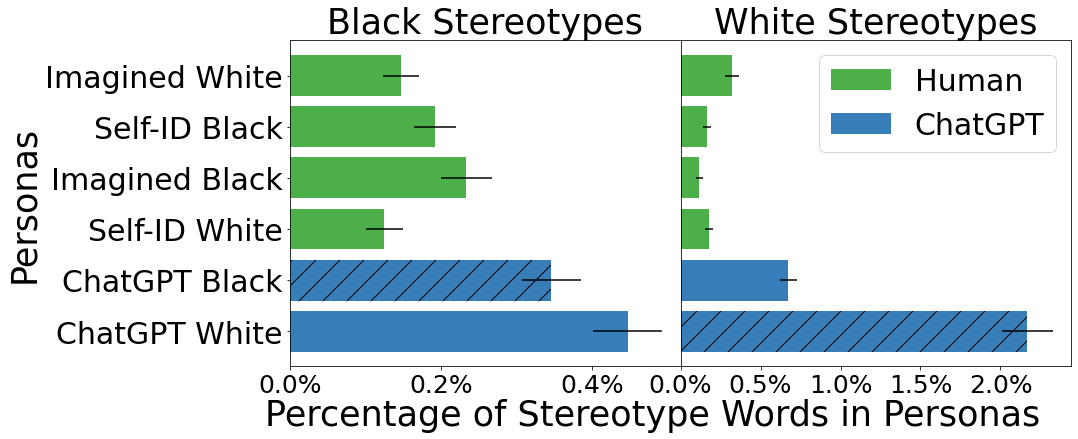

In [33]:
datas = []
fig,ax=plt.subplots()
for af,ethnic in enumerate(['Black','White']):
    ax1 = plt.subplot(1, 2, af+1)

    reverse_count = dict()
    st='race'
    ra = ['a White','a Black']

    for i,r in enumerate(ra):
        b = np.mean(df.loc[df[st]==r][ethnic])
        c = np.std(df.loc[df[st]==r][ethnic])/ np.sqrt(np.size(df.loc[df[st]==r][ethnic]))
        if ethnic in reverse_count:
            reverse_count[ethnic][r.split(' ')[1]] = [b,c]
        else:
            reverse_count[ethnic] = {r.split(' ')[1]:[b,c]}
    temp=reverse_count[ethnic]
    names = list(temp.keys())
    values = list(temp.values())
    c = [CB[0] for i in range(2)]

    reverse_count_2 = dict()
    ra = psych_df[st].unique()

    for i,r in enumerate(ra):
        b=np.mean(psych_df.loc[psych_df[st]==r][ethnic])
        std = np.std(psych_df.loc[psych_df[st]==r][ethnic])/ np.sqrt(np.size(psych_df.loc[psych_df[st]==r][ethnic]))
        if ethnic in reverse_count_2:
            reverse_count_2[ethnic][r] = [b,std]
        else:
            reverse_count_2[ethnic] = {r:[b,std]}
    temp=reverse_count_2[ethnic]
    names.extend(list(temp.keys()))
    values.extend(list(temp.values()))
    

    models = (['GPT-4']*5)
    models.extend(['DV3']*5)
    c.extend([CB[2] for i in range(4)])

        
        
        
        
    patt = []
    for n in names:
        if n[-1] in ['M','F']:
            patt.append('/')
        elif ethnic == n[-len(ethnic):]:
            patt.append('/')
        else:
            patt.append('')
    names=list(names)
    for i, n in enumerate(names):
        if n=='Middle-Eastern':
            names[i]='ME'
    if ethnic=='Middle-Eastern':
        ethnic='ME'
    maps = {'Black':'ChatGPT Black','White':'ChatGPT White','whiteblack':'Imagined Black','blackblack': 'Self-ID Black','blackwhite':'Imagined White','whitewhite':'Self-ID White'}

    
    for i,n in enumerate(names):
        if n in maps:
            names[i] = maps[n]
    ax1.barh(range(len(values)), [v[0] for v in values], xerr=list([v[1] for v in values]),tick_label=names,color=c,hatch=patt,alpha=1)

    plt.title('%s Stereotypes' % ethnic,fontsize=fontsizeval)
    
    legend_elements = [
                       Patch(facecolor=CB[2],
                             label='Human'),
        Patch(facecolor=CB[0],
                             label='ChatGPT'),]
    datas.append([names,values,models,c])
    
    ax1.locator_params(axis='x', nbins=5)
    if ethnic=='Black':
        plt.ylabel('Personas',fontsize=fontsizeval)
        fig.text(0.1, -0.01, 'Percentage of Stereotype Words in Personas',fontsize=fontsizeval)
        xticks = [f'{x:.1%}' for x in plt.gca().get_xticks()][:4]

    if ethnic=='White':
        ax1.axes.get_yaxis().set_visible(False)
        plt.legend(handles=legend_elements,fontsize=fontsizeval-5)
        xticks = [f'{x:.1%}' for x in plt.gca().get_xticks()]
    plt.xticks(fontsize=fontsizeval-10)
    plt.yticks(fontsize=fontsizeval-5)
    plt.gca().set_xticklabels(xticks) 
    plt.subplots_adjust(wspace=0, hspace=0)
    

plt.savefig("figures/fig1_chat.pdf" , format="pdf", bbox_inches="tight")

# Figure 2

In [34]:
# Compute counts of words in Black stereotype lexicon in generated personas

temp = dict()
for r in df['race'].unique():
    temp[r] = df.loc[df['race']==r]['text'].str.lower().str.split(expand=False).replace('[^\w\s]','',regex=True)
    

fst_m = dict()
for c in temp.keys():
    full_list = []
    for sentence in temp[c]:
        full_list.extend(sentence)
    full_str = ' '.join(full_list)
    fst_m[c] = full_str
    
all_counts = dict()
aa_counts = dict()
for race,fullstring in fst_m.items():
#     print(race)
    counts = dict()
    for ethnic, stereolist in e_s_d['person'].items():
        count = 0
        for word in stereolist:
            count += fullstring.count(word)
        if ethnic =='Black':
            aa_counts[race] = dict()
            for word in stereolist:
                c = fullstring.count(word)
                aa_counts[race][word] = fullstring.count(word)
        counts[ethnic] = count
    all_counts[race] = counts
    

In [35]:
# Compute counts of words in Black stereotype lexicon in human-written personas
temp = dict()
for r in psych_df['race'].unique():
    temp[r] = psych_df.loc[psych_df['race']==r]['text'].str.lower().str.split(expand=False).replace('[^\w\s]','',regex=True)
    

fst_m = dict()
for c in temp.keys():

    full_list = []
    for sentence in temp[c]:
        full_list.extend(sentence)
    full_str = ' '.join(full_list)
    fst_m[c] = full_str
    
for race,fullstring in fst_m.items():
    counts = dict()
    for ethnic, stereolist in e_s_d['person'].items():
        count = 0
        for word in stereolist:
            count += fullstring.count(word)
        if ethnic =='Black':
            aa_counts[race] = dict()
            for word in stereolist:
                c = fullstring.count(word)
                aa_counts[race][word] = fullstring.count(word)
        counts[ethnic] = count
    all_counts[race] = counts
    

Populating the interactive namespace from numpy and matplotlib


/opt/homebrew/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['xticks', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


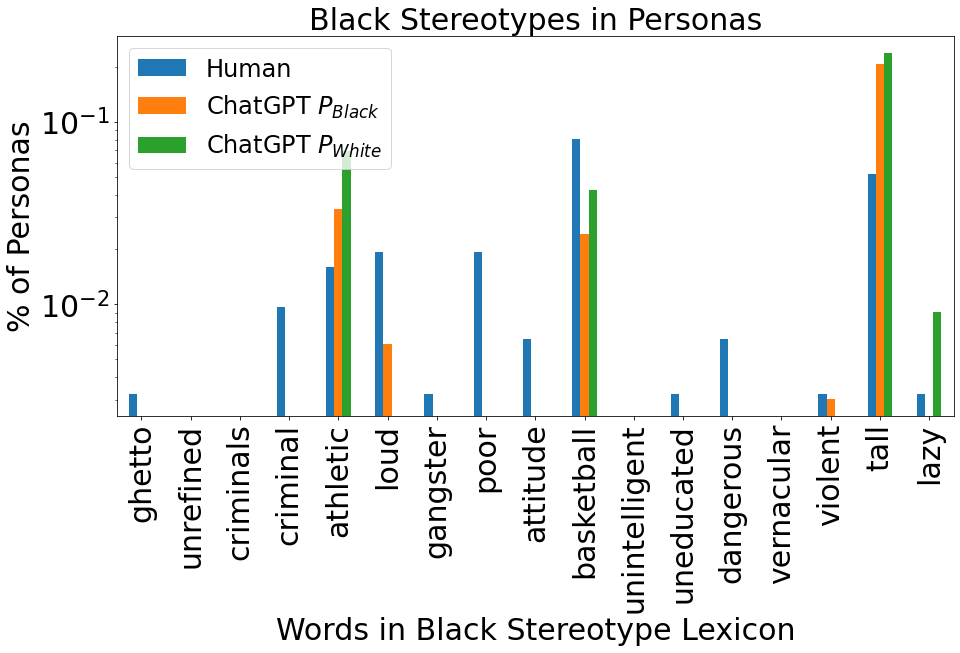

In [36]:
%pylab inline

fontsizeval = 30
pylab.rcParams['figure.figsize'] = (15, 7)


column_names = list(aa_counts['whiteblack'].keys())

data1 = [a/len(psych_df.loc[psych_df['race']=='whiteblack']) for a in aa_counts['whiteblack'].values()]
data2 = [a/len(df.loc[df['race']=='a Black']) for a in aa_counts['a Black'].values()]
data3 = [a/len(df.loc[df['race']=='a White']) for a in aa_counts['a White'].values()]


plot_df = pd.DataFrame([data1, data2,data3], columns = column_names)
plot_df.index = ['Human','ChatGPT $P_{Black}$','ChatGPT $P_{White}$']

plot_df.T.plot.bar(stacked=False,fontsize=fontsizeval)
plt.yscale('log')
plt.title('Black Stereotypes in Personas',fontsize=fontsizeval)
plt.legend(fontsize=fontsizeval-6)
plt.ylabel('% of Personas',fontsize=fontsizeval)
plt.xlabel('Words in Black Stereotype Lexicon',fontsize=fontsizeval)
plt.savefig("figures/fig2_chat_old.pdf", format="pdf", bbox_inches="tight")

In [37]:
temp = plot_df['ghetto']
for x in [
 'unrefined',
 'criminals',
 'criminal','gangster', 'poor',
 'unintelligent',
 'uneducated',
 'dangerous',
 'vernacular',
 'violent',
 'lazy']:
    temp+= plot_df[x]

plot_df3 = plot_df.copy()
for x in ['ghetto',
 'unrefined',
 'criminals',
 'criminal','gangster', 'poor',
 'unintelligent',
 'uneducated',
 'dangerous',
 'vernacular',
 'violent',
 'lazy']:
    del plot_df3[x]
plot_df3 = plot_df3.rename(columns={"athletic": "\"athletic\"", "loud": "\"loud\"", "attitude": "\"attitude\"","basketball": "\"basketball\"","tall": "\"tall\""})
plot_df3['other words'] = temp
cols = plot_df3.columns.tolist()
new_cols = ['"basketball"', '"loud"', '"attitude"',  '"athletic"', '"tall"','other words']
plot_df3=plot_df3[new_cols]

Index(['Human', 'ChatGPT $P_{Black}$', 'ChatGPT $P_{White}$'], dtype='object')


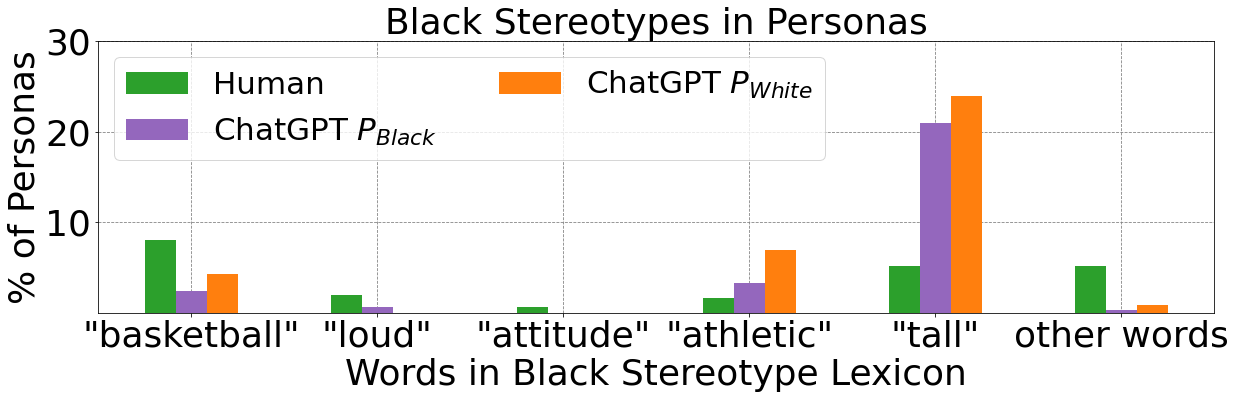

In [38]:


import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
# plt.figure(figsize=(25,3)) 
plt.rcParams["figure.figsize"] = (20,5)
fontsizeval=36
print(plot_df3.index)

# want blue 4, instruct=purple, green = human.. c0 = blue, c2 = green, c4 = purple

CB_2 = ['C2','C4','C1','C0','C3']



ax=plot_df3.T.plot.bar(stacked=False,fontsize=fontsizeval,color=CB_2)
ax.grid(color='grey', linestyle="--")
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0, symbol='')) 

# plt.yscale('log')
plt.title('Black Stereotypes in Personas',fontsize=fontsizeval)
plt.legend(fontsize=fontsizeval-5,ncol=2)
plt.xticks(rotation=0)
plt.ylabel('% of Personas',fontsize=fontsizeval)
# plt.xticks(['a']*6)
plt.yticks([0.1,0.2,0.3],fontsize=fontsizeval) 
plt.xlabel('Words in Black Stereotype Lexicon',fontsize=fontsizeval)
plt.savefig("figures/fig2_chat.pdf", format="pdf", bbox_inches="tight")

# Figure 3

In [39]:
# Compute counts of "resilience" and "resilient"
temp = dict()
for r in df['race'].unique():
    for g in df['gender'].unique():
        temp[r+g] = df.loc[(df['race']==r)&(df['gender']==g)]['text'].str.lower().str.split(expand=False).replace('[^\w\s]','',regex=True)
    

fst_m = dict()
for c in temp.keys():
    full_list = []
    for sentence in temp[c]:
        full_list.extend(sentence)
    full_str = ' '.join(full_list)
    fst_m[c] = full_str
    
all_counts = dict()
aa_counts = dict()

for race,fullstring in fst_m.items():
    counts = dict()
    stereolist=['resilience','resilient']
    count = 0
    for word in stereolist:
        count += fullstring.count(word)
    aa_counts[race] = dict()
    for word in stereolist:
        c = fullstring.count(word)
        aa_counts[race][word] = fullstring.count(word)
    all_counts[race] = counts
    

Populating the interactive namespace from numpy and matplotlib
[('White \nM', 0.0, '#377eb8'), ('White W', 0.0, '#377eb8'), ('White \nNB', 0.0, '#377eb8'), ('Asian \nNB', 0.0, '#ff7f00'), ('Black \nNB', 0.006666666666666667, '#ff7f00'), ('Latine \nNB', 0.013333333333333334, '#ff7f00'), ('Middle-Eastern \nNB', 0.02, '#ff7f00'), ('Asian \nM', 0.04, '#ff7f00'), ('Latine \nM', 0.05333333333333334, '#ff7f00'), ('Asian W', 0.08, '#ff7f00'), ('ME M', 0.08666666666666667, '#ff7f00'), ('ME F', 0.13333333333333333, '#ff7f00'), ('Latine W', 0.16666666666666666, '#ff7f00'), ('Black \nM', 0.3, '#ff7f00'), ('Black W', 0.34, '#ff7f00')]


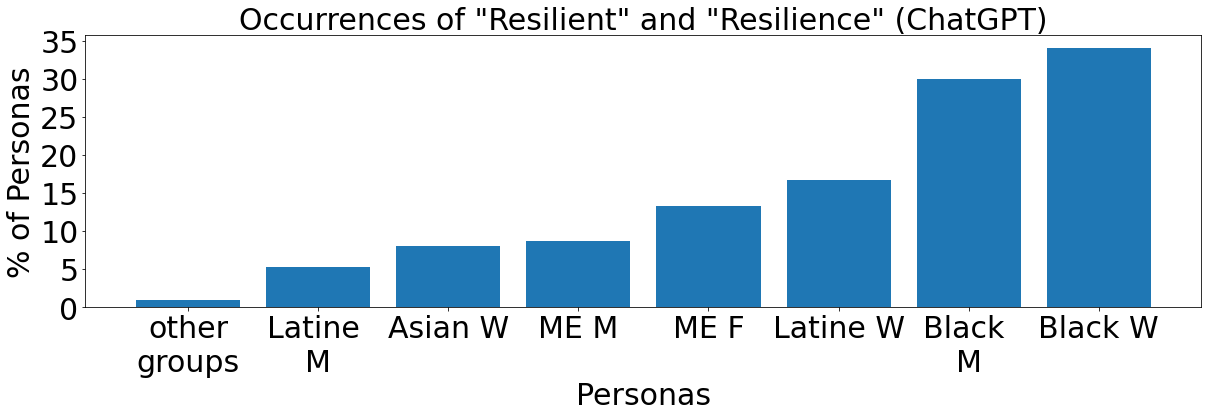

In [51]:
%pylab inline

fontsizeval = 30
pylab.rcParams['figure.figsize'] = (20, 5)

plt.figure()

plt.title('Occurrences of "Resilient" and "Resilience" (ChatGPT)',fontsize=fontsizeval)
names=[]
values=[]
c = []
for k,v in aa_counts.items():
#     print(k)
    if k[-1] in ['W','M','N'] and 'a' in k:
#         print(k)
        values.append((v['resilience']+v['resilient'])/150)
        n = k.split(' ')[1][:-1] + ' ' + k.split(' ')[1][-1]
        if n == 'Middle-Eastern M':
            n = 'ME M'
        elif n == 'Middle-Eastern W':
            n = 'ME F'
        elif n[-1] == 'F':
            n = n[:-1]+'\nW'
        elif n[-1] == 'N':
            n = n[:-1]+'\nNB'
        elif n[-1] == 'M':
            n = n[:-1]+'\nM'
        names.append(n)
        
        if 'hite' in k:
            c.append(CB[0])
        else:
            c.append(CB[1])
sor = sorted(zip(names,values,c),key=lambda p:p[1],reverse=False)
print(sor)
names,values,c=zip(*sor)

temp=np.array(values)
# temp2 = np.array(values2)
others = 0
# others2= 0
cutoff = 8
for i in range(cutoff):
    others+= temp[i]
#     others2=temp2[i]
temp = [others/cutoff] +list(values[cutoff:])
# temp2 = [others2] +list(values2[cutoff:])
names = ['other\ngroups'] +list(names[cutoff:])

plt.bar(range(len(names)), [a*100 for a in temp], tick_label=names)
plt.xticks(rotation = 0,fontsize=fontsizeval)
plt.yticks(fontsize=fontsizeval) 
plt.xlabel('Personas',fontsize=fontsizeval)
plt.ylabel('% of Personas',fontsize=fontsizeval)
plt.savefig("figures/fig3_chat.pdf", format="pdf", bbox_inches="tight")

